# Random Ronchigram generator

**Note**: In order to use it on a specific machine, you should build machine interface (setX and get_state functions).


In [1]:
import pickle
import numpy as np
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib qt
import hyperspy.api as hs
from PIL import Image
import cv2
from cv2 import VideoWriter, VideoWriter_fourcc
import glob
import math

In [2]:
# CNN related libraries
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## Get CNN model ready

In [15]:
# VGG16 model with self-defined top fully-connected layers
# training data: 50,000 frames of simulated Ronchigrams, 70 mrad collection angle, 100 mrad simulation range, fine aberration range
# training hyper-parameters: 
#  learning rate: 8.5e-5/5.5e-5
#  decay: 1e-7
#  momentum: 0.9
#  batch size: 20
#  training epoch: 50/100

model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
print('Model loaded')
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.0))
top_model.add(Dense(1,activation=None))

new_model = Sequential()
for l in model.layers:
    new_model.add(l)
new_model.add(top_model)
new_model.load_weights('CoarseCNNtraining/VGG16/OptimalPar_newData/Test2_Normalize/Final_model.h5')
model = new_model
del top_model, new_model

Model loaded


In [13]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input  

In [4]:
# Read in the experimental image seires
# %matplotlib qt
# temp = hs.load("ExperimentalData/030221/Ceta_CarbonSupport_0.064s/A1series_1.ser")
# temp = hs.load("ExperimentalData/030221/Ceta_CarbonSupport_0.064s/A2series_1.ser")
# temp = hs.load("ExperimentalData/030221/Ceta_CarbonSupport_0.064s/B2series_1.ser")
temp = hs.load("ExperimentalData/030221/Ceta_CarbonSupport_0.064s/C3series_1.ser")
# temp = hs.load("ExperimentalData/030221/Ceta_CarbonSupport_0.064s/A3series_1.ser")
# temp = hs.load("ExperimentalData/030221/Ceta_CarbonSupport_0.064s/S3series_1.ser")
# temp.plot()

In [5]:
# Cell to save video
temp_npy = np.asarray(temp)
index = np.where(temp_npy[:,128,128]!=0)
temp_npy_cropped = temp_npy[index,128-105:128+105, 128-105:128+105]
temp_npy_cropped = np.squeeze(temp_npy_cropped)
temp_npy_cropped[temp_npy_cropped>3000] = 3000
temp_npy_cropped[temp_npy_cropped<1500] = 1500

FPS = 24
width = 210
height = 210

frameSize = (210, 210)
fourcc = VideoWriter_fourcc(*'MP42')
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')  
path = "ExprertimentalData/030221/Ceta_CarbonSupport_0.064s/"
video = cv2.VideoWriter('A1.mov',cv2.VideoWriter_fourcc(*'MP42'), 24, frameSize)

for i in range(temp_npy_cropped.shape[0]):
    frame = temp_npy_cropped[i, :,:]
    frame = (frame - np.amin(frame))/(np.amax(frame) - np.amin(frame)) * 255
    frame = frame.astype('uint8')
    frame = np.dstack((frame, frame, frame))
    video.write(frame)

In [16]:
temp_npy = np.asarray(temp)
index = np.where(temp_npy[:,128,128]!=0)
temp_npy_cropped = temp_npy[index,128-105:128+105, 128-105:128+105]
temp_npy_cropped = np.squeeze(temp_npy_cropped)
print(temp_npy_cropped.shape)
x_list = []
for i in range(temp_npy_cropped.shape[0]):
    frame = temp_npy_cropped[i,:,:]
    frame[frame>3000] = 3000
    frame[frame<2000] = 1500
    frame = scale_range(frame.astype('float'), 0, 1)
    frame = np.array(Image.fromarray(frame).resize(size=(128,128)))
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
    
x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
prediction =model.predict(x_list, batch_size = 10)

(219, 210, 210)


Text(0, 0.5, 'CNN $\\epsilon_\\chi$ (pm•rad)')

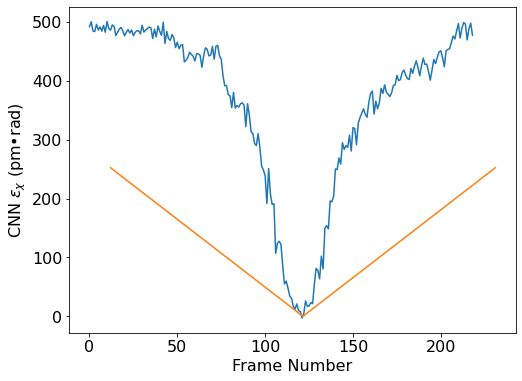

In [19]:
# Plot the overall trend

# B2_list = np.linspace(1e-6, -1e-6, num=temp_npy_cropped.shape[0])
A1_list = np.linspace(1e-7, -1e-7, num=temp_npy_cropped.shape[0])
# A2_list = np.linspace(1e-6, -1e-6, num=temp_npy_cropped.shape[0])
# C3_list = np.linspace(100e-6, -100e-6, num=temp_npy_cropped.shape[0])
# A3_list = np.linspace(1.5e-6, -1.5e-6, num=temp_npy_cropped.shape[0])
# S3_list = np.linspace(10e-6, -10e-6, num=temp_npy_cropped.shape[0])
emit_list = A1_list * 0
for i in range(len(emit_list)):
    emit_list[i] = CalcEmittance(A1 = A1_list[i])
    
fig = plt.figure(figsize=[8,6])
plt.plot(prediction*468.3, label='CNN prediction')
plt.plot(np.linspace(12, 12 + len(emit_list), num=len(emit_list)), emit_list, label = 'Theory')
# plt.legend(fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Frame Number', fontsize = 16)
plt.ylabel('CNN $\epsilon_\chi$ (pm\u2022rad)', fontsize=16)


In [185]:
fig = plt.figure(figsize = (8,6))

temp_npy = np.asarray(temp)
index = np.where(temp_npy[:,128,128]!=0)
temp_npy_cropped = temp_npy[index,128-105:128+105, 128-105:128+105]
data = temp_npy_cropped[:,:,:]  # deterministic random data
plt.hist(np.ndarray.flatten(data), bins='auto')
plt.ylabel('Occurance', fontsize = 16)
plt.xlabel('Pixel Intensity', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

In [18]:
# Calculate theoretical emittance
def CalcEmittance(A1=0, A2=0, B2=0, C3=0, A3=0, S3=0):
    
    simdim = 40 # collection limit in mrad
    imdim = 128 # pixel size of the grid
    ap_size = 40 # emittance aperture size in unit of mrad
    px_size = simdim / (imdim/2) # pixel size in mrad
    px_size = px_size / 1000 # pixel size in rad

    # Generate angle grid, in unit of radian
    x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
    xv, yv = np.meshgrid(x, y)

    # Generate aberration grid, 3.19e12 comes from 2*pi/lambda, in unit of m^-1
    abr = xv * 0
    abr = abr + A1 / 2 * (xv ** 2 - yv ** 2)
    abr = abr + A2 * yv * (yv ** 2 - 3 * xv ** 2) / 3
    abr = abr + B2 * xv * (xv ** 2 + yv ** 2)
    abr = abr + C3 * (xv ** 2 + yv ** 2) ** 2 / 4
    abr = abr + A3 * (xv * yv ** 3 + xv ** 3 * yv)
    abr = abr + S3 * (xv ** 2 + yv ** 2) * xv * yv * 2
    abr = abr * 3.19e12
    
    abr_gradient = np.gradient(abr)
    abr_gradient[0], abr_gradient[1] = abr_gradient[0] / px_size, abr_gradient[1] / px_size

    # Calculate aperture factor and mask, for 40 mrad
    apt_fact = 1/math.pi/(ap_size/1000)/(ap_size/1000) # factor from aperture, correspond to A^2
    apt_mask = np.sqrt(xv*xv + yv*yv) < (ap_size / 1000) # aperture mask
    apt_mask = apt_mask * apt_fact # absorb the A^2 factor from the aperture into the aperture mask

    # calculte the three integrals numerically by adding up within aperture mask
    emit_1 = np.sum(apt_mask*(abr_gradient[0]*abr_gradient[0] + abr_gradient[1]*abr_gradient[1])) * px_size**2
    emit_2 = np.sum(apt_mask*(xv*xv + yv*yv)) * px_size**2
    emit_3 = np.sum(apt_mask*(abr_gradient[0]*yv + abr_gradient[1]*xv)) * px_size**2
    emit = np.sqrt(emit_1 * emit_2 - emit_3 * emit_3)
    
    return emit

In [ ]:
import matplotlib
matplotlib.use('Agg')
# generate and save image series
path = "ExperimentalData/030221/Ceta_CarbonSupport_0.064s/C3series/"
for i in range(temp_npy_cropped.shape[0]):
    frame = temp_npy_cropped[i,:,:]
    frame = scale_range(frame.astype('float'), 0, 255)
    frame = np.array(Image.fromarray(frame).resize(size=(128,128)))
    
    fig = plt.figure(figsize=[15,7])
    ax1 = plt.subplot(121)
    ax1.imshow(frame, extent=[-40,40,-40,40])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    ax2 = plt.subplot(122)
    ax2.plot(prediction*468.3)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Frame Number', fontsize = 16)
    plt.ylabel('CNN $\epsilon_\chi$ (pm\u2022rad)', fontsize=16)
    ax2.scatter(i, prediction[i]*468.3, c='r', zorder=1)
    plt.savefig(path + "{:0>3d}".format(i)+".png")
#     cv2.imwrite("ExperimentalData/022721/RonchigramSeries/A2series4/"+"{:0>3d}".format(i)+".png", frame)

In [99]:
frame = cv2.imread(os.path.join(image_folder, images[100])) 
plt.imshow(frame)

In [96]:
# Make the image series into a video
image_folder = 'ExperimentalData/022721/RonchigramSeries/A2series4/.' # make sure to use your folder 
video_name = 'mygeneratedvideo.avi'
# os.chdir("C:\\Python\\Geekfolder2") 

images = [img for img in os.listdir(image_folder) 
          if img.endswith(".jpg") or
             img.endswith(".jpeg") or
             img.endswith("png")] 

# Array images should only consider 
# the image files ignoring others if any 
images.sort()
# print(images)  

frame = cv2.imread(os.path.join(image_folder, images[0])) 

# setting the frame width, height width 
# the width, height of first image 
height, width, layers = frame.shape   

video = cv2.VideoWriter(video_name, 0, 1, (width, height))  

# Appending the images to the video one by one 
for image in images:  
    video.write(cv2.imread(os.path.join(image_folder, image)))  

# Deallocating memories taken for window creation 
# cv2.destroyAllWindows()  
video.release()  # releasing the video generated 

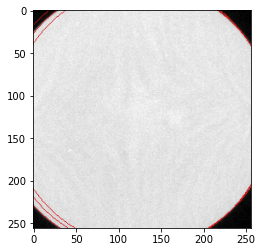

[156 159 153]


In [29]:
# Find the radius of the aperture to calibrate diffraction pattern pixel size
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
temp_npy = np.asarray(temp)
integrated = np.sum(temp_npy, axis=0)
image = img_as_ubyte(integrated/np.amax(integrated))
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)


# Detect two radii
hough_radii = np.arange(150, 200, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()
print(radii)

In [6]:
simdim = 40 # collection limit in mrad
imdim = 128 # pixel size of the grid
ap_size = 40 # emittance aperture size in unit of mrad
px_size = simdim / (imdim/2) # pixel size in mrad
px_size = px_size / 1000 # pixel size in rad

# Generate angle grid, in unit of radian
x = np.linspace(-simdim / 1000, simdim / 1000, imdim)
y = np.linspace(-simdim / 1000, simdim / 1000, imdim)
xv, yv = np.meshgrid(x, y)

# Generate aberration grid, 3.19e12 comes from 2*pi/lambda, in unit of m^-1
abr = xv * 0
abr = abr + 1 * (xv**2 - yv**2)

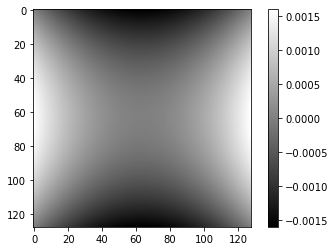

In [20]:
plt.imshow(abr)
plt.colorbar()